## This is Dimas' Notebook

# Basic COVID-19 Detection by X-Ray Image Classification

These code mainly adapted from Adrian Rosebrock's on https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

First we import the necessary packages. For building and training models, we use **tf.keras**. We also use **scikit-learn** for data preprocessing and report. **matplotlib** used for data visualization. For data building and processing we use **os**, **imutils**, **numpy**, and **cv2**.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Import the dataset

We used dataset from public source provided by Dr. Cohen (https://github.com/ieee8023/covid-chestxray-dataset) and Paul Mooney (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). To simplify dataset importing to the model, we first clone it to our GitHub repository.

In [2]:
GIT_PATH = "https://github.com/sanggusti/bangkit_assessment_1.git"
!git clone "{GIT_PATH}"
%cd ./bangkit_assessment_1
%ls
%pwd

Cloning into 'bangkit_assessment_1'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 86 (delta 12), reused 14 (delta 5), pack-reused 0
Unpacking objects: 100% (86/86), done.
/content/bangkit_assessment_1
arief_notebook.ipynb  dimas_notebook.ipynb  README.md
dataset/              gusti_notebook.ipynb


'/content/bangkit_assessment_1'

## Preprocess the data

### Feature and label building

List the directory of each image from the dataset

In [3]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

[INFO] loading images...


Building labels and pixel data by looping over the image paths from the dataset

In [0]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

Normalization of pixel value and convert to numpy array

In [0]:
data = np.array(data) / 255.0
labels = np.array(labels)

Build one-hot encoding on the labels

In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Data partition
Partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

### Training data augmentation
Initialize the training data augmentation object

In [0]:
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

## Build the model

### Hyperparameter tuning

Initiate hyperparameters: learning rate, number of epochs, and batch size

In [0]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

### Load the network model

Load the VGG16 network, ensuring the head FC layer sets are left off

In [10]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 0s 0us/step


Construct the head of the model that will be placed on top of the the base model

In [0]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

Place the head FC model on top of the base model (this will become the actual model we will train)

In [0]:
model = Model(inputs=baseModel.input, outputs=headModel)

Loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

In [0]:
for layer in baseModel.layers:
	layer.trainable = False

### Compile the model

In [14]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


## Train the model

### Feed the model
Train the head of the network by fitting the data.

In [15]:
print("[INFO] training head...")
H = model.fit_generator(
      trainAug.flow(trainX, trainY, batch_size=BS),
      steps_per_epoch=len(trainX) // BS,
      validation_data=(testX, testY),
      validation_steps=len(testX) // BS,
      epochs=EPOCHS)

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
5/5 [==============================] - 21s 4s/step - loss: 0.9114 - accuracy: 0.4500 - val_loss: 0.6585 - val_accuracy: 0.8000
Epoch 2/25
5/5 [==============================] - 21s 4s/step - loss: 0.6637 - accuracy: 0.6500 - val_loss: 0.6450 - val_accuracy: 0.7000
Epoch 3/25
5/5 [==============================] - 21s 4s/step - loss: 0.7110 - accuracy: 0.5000 - val_loss: 0.6401 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 21s 4s/step - loss: 0.8054 - accuracy: 0.5250 - val_loss: 0.6123 - val_accuracy: 0.8000
Epoch 5/25
5/5 [==============================] - 21s 4s/step - loss: 0.7722 - accuracy: 0.4000 - val_loss: 0.6026 - val_accuracy: 0.9000
Epoch 6/25
5/5 [==============================] - 21s 4s/step - loss: 0.6096 - accuracy: 0.6750 - val_loss: 0.5850 - val_accuracy: 0.9000
Epoch 7/25
5/5 [==============================] - 21s 4s/step - loss: 0.

### Make predictions
Perform prediction on the testing set

In [16]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


For each image in the testing set we need to find the index of the label with corresponding largest predicted probability

In [0]:
predIdxs = np.argmax(predIdxs, axis=1)

### Prediction evaluation

Show a nicely formatted classification report

In [18]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



Compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity

In [0]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

Show the confusion matrix, accuracy, sensitivity, and specificity

In [20]:
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


### Performance visualization
Plot the training loss and accuracy

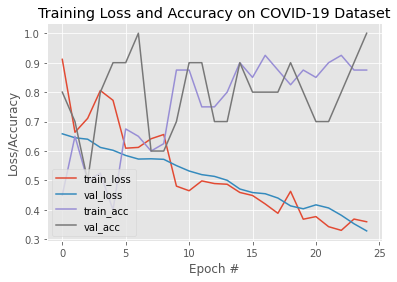

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("assignment5_covid19_performance.png")

## Exporting model

In [22]:
print("[INFO] saving COVID-19 detector model...")
model.save("assignment5_covid19.model", save_format="h5")

[INFO] saving COVID-19 detector model...


In [23]:
%ls

arief_notebook.ipynb                 dataset/              README.md
assignment5_covid19.model            dimas_notebook.ipynb
assignment5_covid19_performance.png  gusti_notebook.ipynb
